In [10]:
from __future__ import  print_function

import pandas as pd
import sklearn.metrics as metrics
import torch.nn as nn
from torch.autograd import Variable
import torchvision.models as models
from data_preprocess.img_process import *

import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

In [3]:
state_path_101 = '../results/best_params/res101_73_ckpt.t7'

state_path_152 = '../results/best_params/res152_74_ckpt.t7'

device_id_all = [0, 1, 2, 3]
use_cuda = torch.cuda.is_available()

# load best resnet101
model_res101 = models.resnet101()
num_ftrs = model_res101.fc.in_features
model_res101.fc = nn.Linear(num_ftrs, NUM_CLASSES)
model_res101 = nn.DataParallel(model_res101, device_ids=device_id_all)

state_101 = torch.load(state_path_101)
model_name_101 = state_101['model_name']
state_dict_101 = state_101['model_param']
model_res101.load_state_dict(state_dict_101)
print(model_name_101)

# load best resnet152
model_res152 = models.resnet152()
num_ftrs = model_res152.fc.in_features
model_res152.fc = nn.Linear(num_ftrs, NUM_CLASSES)
model_res152 = nn.DataParallel(model_res152, device_ids=device_id_all)

state_152 = torch.load(state_path_152)
model_name_152 = state_152['model_name']
state_dict_152 = state_152['model_param']
model_res152.load_state_dict(state_dict_152)
print(model_name_152)

if use_cuda:
    model_res101.cuda()
    model_res152.cuda()

img_transform = img_transform_224
val_set = DogImageLoader(data_type='val', transform=img_transform)
val_loader = data_utils.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_set = DogImageLoader(data_type='test', transform=img_transform)

test_loader = data_utils.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False,
                                    num_workers=4)
print(len(val_set), len(test_set))


def validation(model, data_loader, criterion):
    model.eval()
    use_cuda = torch.cuda.is_available()
    test_loss = 0
    correct = 0
    total = 0
    pred_all = np.empty(0)
    true_all = np.empty(0)
    for batch_idx, (inputs, labels) in enumerate(data_loader):
        if use_cuda:
            inputs, labels = inputs.cuda(), labels.cuda()
        inputs, labels = Variable(inputs, volatile=True), Variable(labels)
        outputs = model(inputs)
        test_loss += criterion(outputs, labels).data[0]
        # get the index of the max log-probability
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.data).cpu().sum()
        true_all = np.concatenate((true_all, labels.data.cpu().numpy().reshape(-1)))
        pred_all = np.concatenate((pred_all, predicted.cpu().numpy().reshape(-1)))
    test_loss /= len(data_loader)
    test_acc = 100.*correct / total
    test_err = 100. - test_acc
    true_all = np.array(true_all).reshape(-1, 1)
    pred_all = np.array(pred_all).reshape(-1, 1)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {:.2f}%, Error: {:.2f}%'.format(test_loss, test_acc, test_err))
    return true_all, pred_all

res10189.9014122036
res15289.3685051958
3753 10593



Test set: Average loss: 0.4045, Accuracy: 88.86%, Error: 11.14%


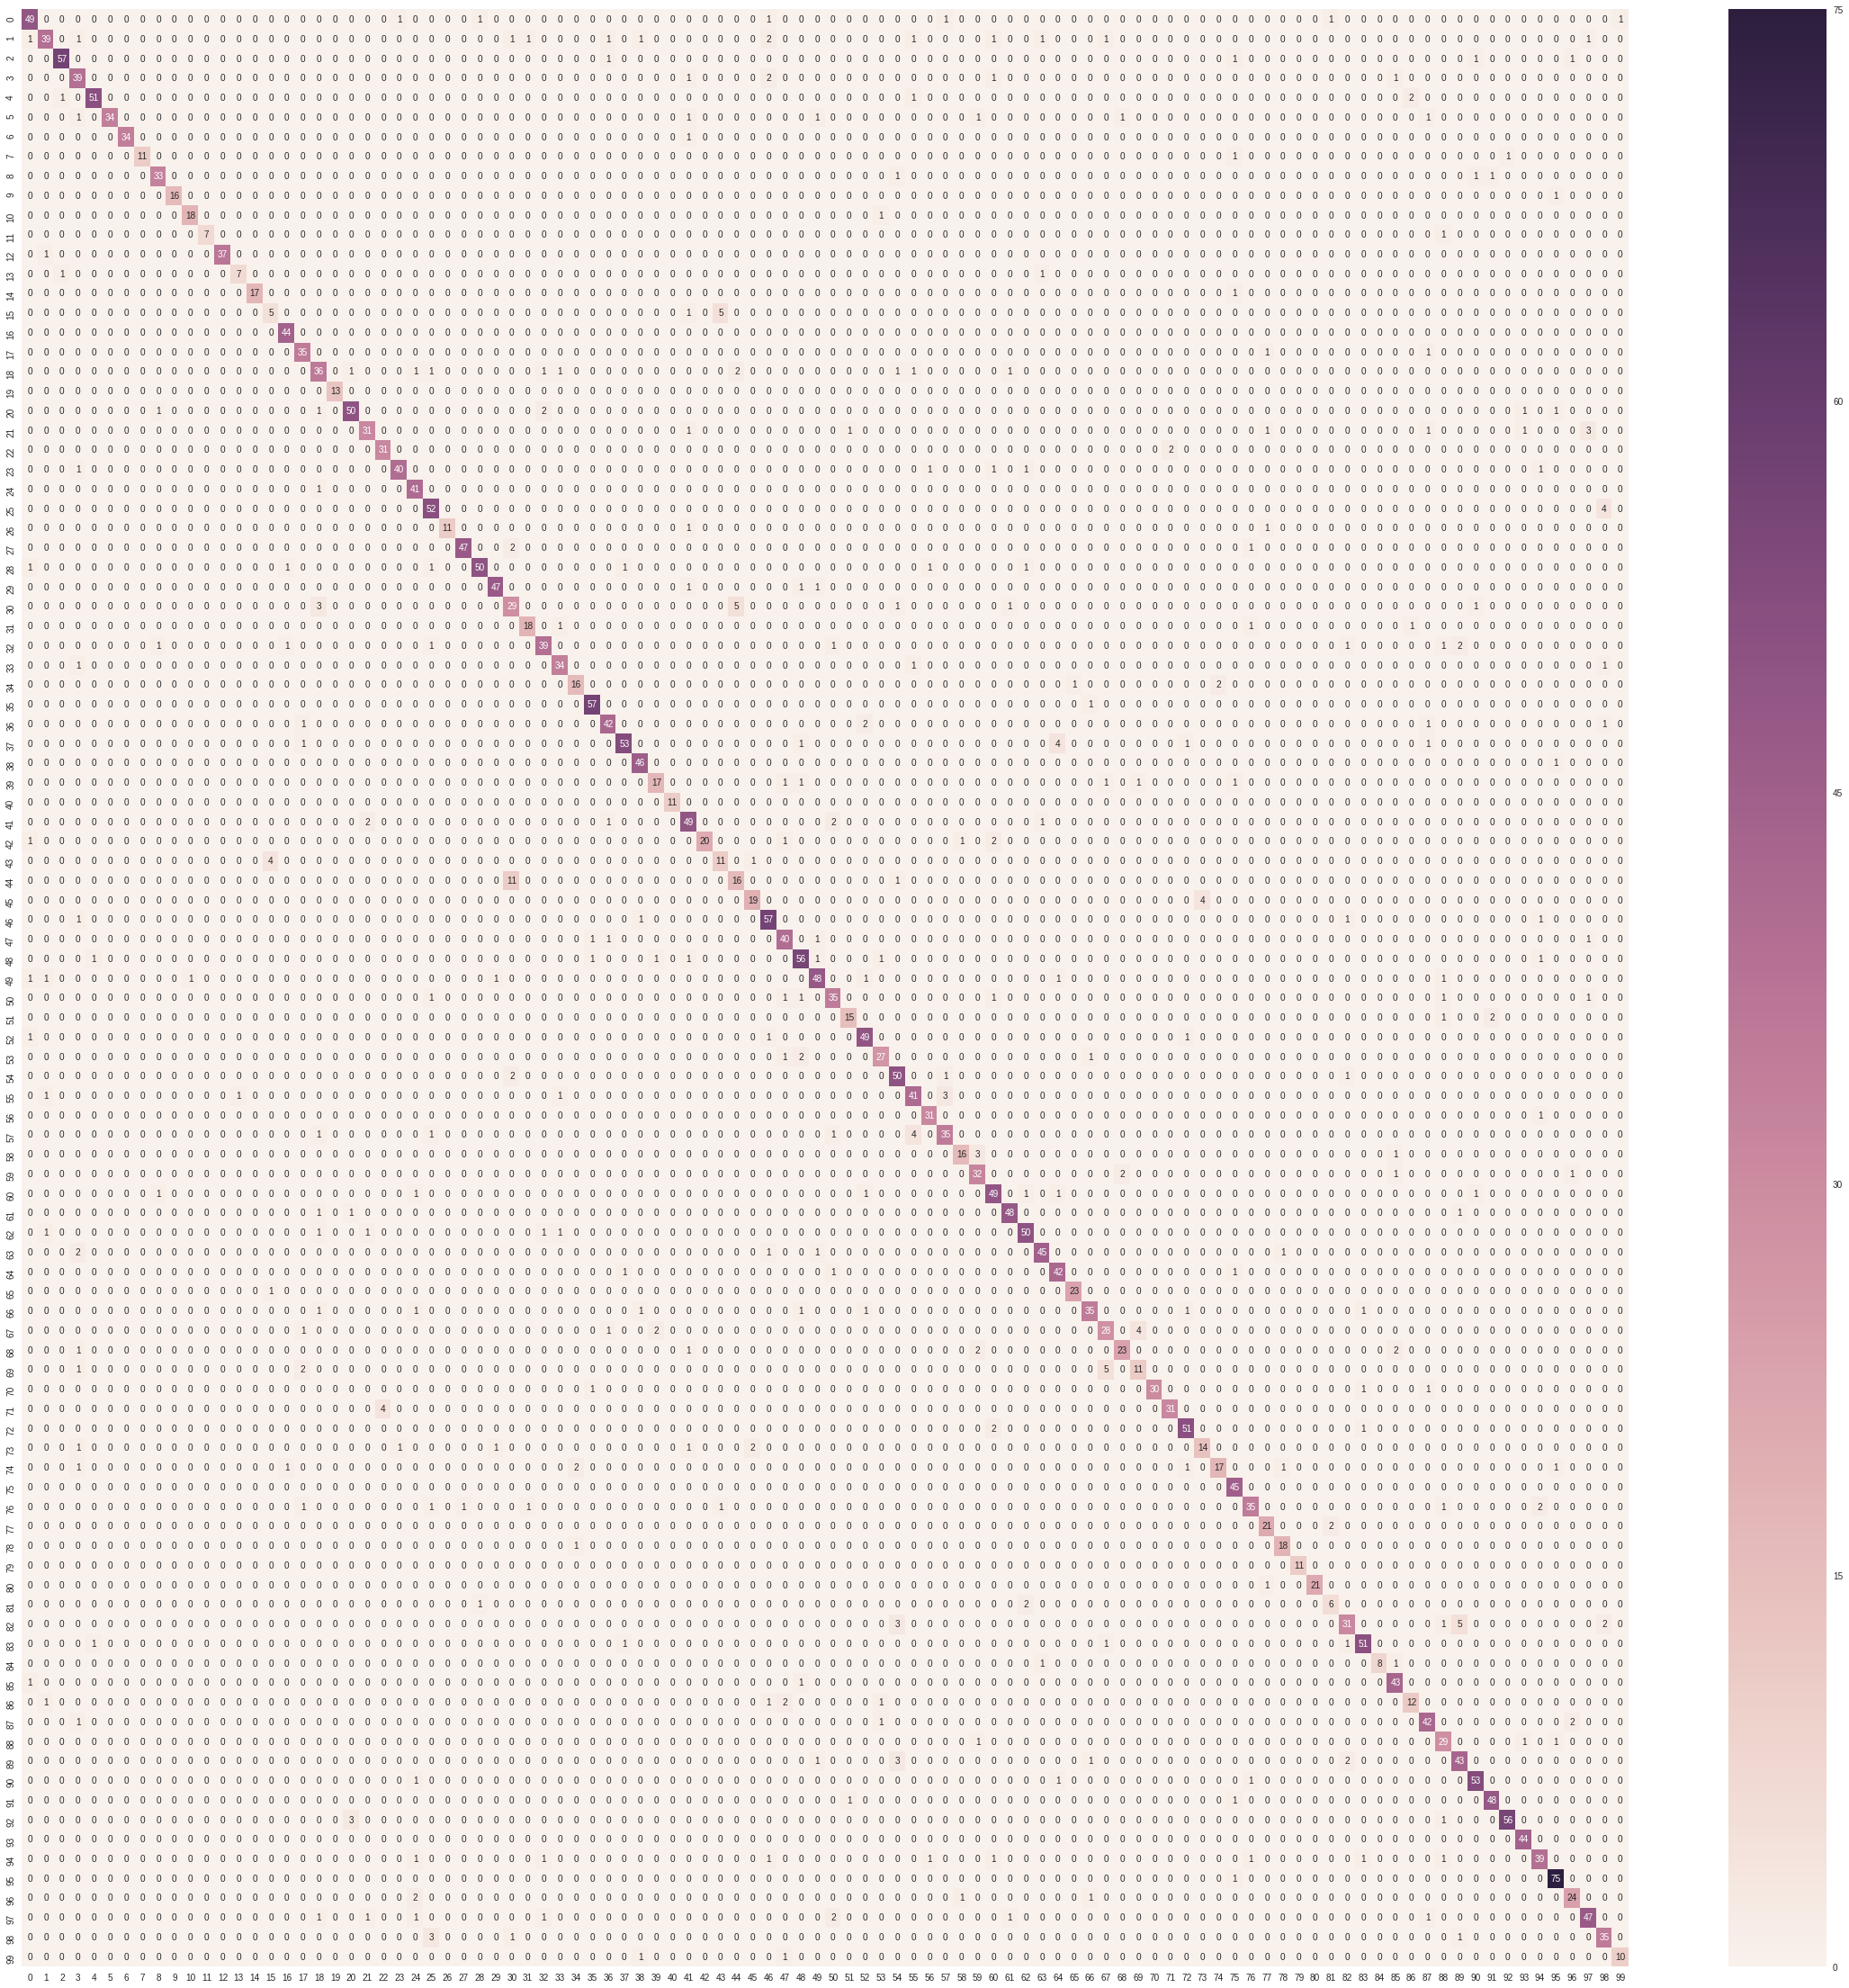

In [7]:
cs = nn.CrossEntropyLoss()
for i in range(1):
    y_true, y_pred = validation(model_res152, val_loader, cs)
    confu_mat = metrics.confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(40, 40))
    sn.heatmap(confu_mat, annot=True)
    plt.show()

In [5]:
import numpy as np
print(len(np.unique(y_true)), len(np.unique(y_pred)))

100 100


In [ ]:
from data_preprocess.img_process import *
all_set = DogImageLoader(data_type='all', transform=img_transform)
train_set = DogImageLoader(data_type='train', transform=img_transform)
val_set = DogImageLoader(data_type='val', transform=img_transform)

In [19]:
all_classes = all_set.classes
train_classes = train_set.classes
val_classes = val_set.classes

In [20]:
print(len(np.unique(all_classes)))
print(len(np.unique(train_classes)))
print(len(np.unique(val_classes)))

134
134
134


In [21]:
print(np.bincount(all_classes))

UnicodeEncodeError: 'decimal' codec can't encode characters in position 0-4: invalid decimal Unicode string